### OBJECTIVE
To develop a CNN-based model for detecting brain tumours in MRI images.

### BACKGROUND
Brain tumours are a serious medical condition that can lead to significant health consequences if not diagnosed and treated promptly. With the increasing volume of medical imaging data, deep learning models, specifically CNNs, have shown great promise in classifying medical images, including MRI scans of brain tumors. The ability to automate the detection of brain tumours can save valuable time in healthcare and improve patient outcomes.
### DATA
The dataset consists of MRI images for brain tumour classification.
https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset


### METHOD
The model preprocesses MRI images by resizing them to 150x150 pixels and normalising pixel values. The training data is augmented with rotations, shifts and flips to improve generalisation, while the validation and test data is only rescaled.

A CNN is designed with convolutional, pooling, batch normalisation and dropout layers. The model is built using the Adam optimiser. Hyperparameters such as learning rate and dropout rate are tuned using TensorBoard logging and performance is evaluated using accuracy, precision and recall metrics.

Finally, the performance of the model is evaluated using a confusion matrix and a classification report.

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPooling2D, AveragePooling2D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Copy the file from the source to the current directory
!cp /content/drive/MyDrive/brain-tumor-mri-dataset_merged_vordsustatud.zip /content

# Unzip the file
!unzip brain-tumor-mri-dataset_merged_vordsustatud.zip

Archive:  brain-tumor-mri-dataset_merged_vordsustatud.zip
   creating: brain-tumor-mri-dataset_merged_vordsustatud/
   creating: brain-tumor-mri-dataset_merged_vordsustatud/Testing/
   creating: brain-tumor-mri-dataset_merged_vordsustatud/Testing/notumour/
  inflating: brain-tumor-mri-dataset_merged_vordsustatud/Testing/notumour/Te-noTr_0000.jpg  
  inflating: brain-tumor-mri-dataset_merged_vordsustatud/Testing/notumour/Te-noTr_0001.jpg  
  inflating: brain-tumor-mri-dataset_merged_vordsustatud/Testing/notumour/Te-noTr_0002.jpg  
  inflating: brain-tumor-mri-dataset_merged_vordsustatud/Testing/notumour/Te-noTr_0003.jpg  
  inflating: brain-tumor-mri-dataset_merged_vordsustatud/Testing/notumour/Te-noTr_0004.jpg  
  inflating: brain-tumor-mri-dataset_merged_vordsustatud/Testing/notumour/Te-noTr_0005.jpg  
  inflating: brain-tumor-mri-dataset_merged_vordsustatud/Testing/notumour/Te-noTr_0006.jpg  
  inflating: brain-tumor-mri-dataset_merged_vordsustatud/Testing/notumour/Te-noTr_0007.jpg  

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values to [0, 1]
    rotation_range=20,          # Random rotations
    width_shift_range=0.2,      # Random horizontal shifts
    height_shift_range=0.2,     # Random vertical shifts
    shear_range=0.2,            # Shear transformations
    zoom_range=0.2,             # Random zoom
    horizontal_flip=True,       # Flip images horizontally
    fill_mode='nearest'         # Fill pixels after transformations
)

# Validation and test data: No augmentation, only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define directories (ensure your data is structured correctly)
train_dir = '/content/brain-tumor-mri-dataset_merged_vordsustatud/Training'
val_dir = '/content/brain-tumor-mri-dataset_merged_vordsustatud/Validation'
test_dir = '/content/brain-tumor-mri-dataset_merged_vordsustatud/Testing'

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),    # Image size must match the model input
    batch_size=32,             # Number of images per batch
    class_mode='categorical'   # Adjust for multi-class classification
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False              # No shuffling for consistent test results
)


Found 3201 images belonging to 2 classes.
Found 421 images belonging to 2 classes.
Found 407 images belonging to 2 classes.


In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jan 19 11:43:13 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np


def test_confusion_matrix(model):
  predictions = model.predict(test_generator)

  predicted_classes = np.argmax(predictions, axis=1)

  true_labels = test_generator.classes
  print(test_generator.class_indices)

  accuracy = accuracy_score(true_labels, predicted_classes)
  print(f"Accuracy: {accuracy}")

  print(classification_report(true_labels, predicted_classes))

  print(confusion_matrix(true_labels, predicted_classes))

  return None



In [35]:
import matplotlib.pyplot as plt

# Function to draw plots
def draw_plots(history):
    f, ax = plt.subplots(2, 2, figsize=(12, 6))

    # Extract history data
    history_data = history.history

    print(history_data.keys())  # Check the exact metric names

    # 1st subplot: training loss and validation loss
    ax[0, 0].plot(history_data['loss'], color='b', label='train_loss')
    ax[0, 0].plot(history_data['val_loss'], color='r', label='val_loss')
    ax[0, 0].legend(loc="upper right")

    # 2nd subplot: training accuracy and validation accuracy
    ax[0, 1].plot(history_data['accuracy'], color='b', label='train_accuracy')
    ax[0, 1].plot(history_data['val_accuracy'], color='r', label='val_accuracy')
    ax[0, 1].legend(loc="lower right")

    # 3rd subplot: training precision and validation precision
    precision_key = [key for key in history_data.keys() if 'precision' in key][0]
    val_precision_key = f'val_{precision_key}'
    ax[1, 0].plot(history_data[precision_key], color='b', label='train_precision')
    ax[1, 0].plot(history_data[val_precision_key], color='r', label='val_precision')
    ax[1, 0].legend(loc="lower right")

    # 4th subplot: training recall and validation recall
    recall_key = [key for key in history_data.keys() if 'recall' in key][0]
    val_recall_key = f'val_{recall_key}'
    ax[1, 1].plot(history_data[recall_key], color='b', label='train_recall')
    ax[1, 1].plot(history_data[val_recall_key], color='r', label='val_recall')
    ax[1, 1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()


In [9]:
import os
import time
from tensorboard.plugins.hparams import api as hp


root_logdir = os.path.join(os.curdir, "logs")
run_name = ''

def get_run_logdir():
    run_id = time.strftime("run_" + run_name + "_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [ ]:
#HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-2, 1e-3, 1e-4, 1e-1, 1e-5]))
#HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-2, 1e-3, 1e-4]))
#HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32, 64, ]))
#HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.3, 0.5]))
#HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
#METRIC_ACCURACY = 'accuracy'

In [10]:
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-3, 1e-4]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.5, 0.7]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
METRIC_ACCURACY = 'accuracy'

In [11]:
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_LEARNING_RATE, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [43]:
def train_test_model(hparams):
    optimizer_name = hparams[HP_OPTIMIZER]
    learning_rate = hparams[HP_LEARNING_RATE]
    if optimizer_name == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("unexpected optimizer name: %r" % (optimizer_name,))

    model = Sequential([
        Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', padding='same',
                            input_shape=(150, 150, 3)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
        BatchNormalization(),
        Conv2D(filters=384, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
        BatchNormalization(),
        Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
        Flatten(),
        Dense(4096, activation='relu', input_dim=(227, 227, 1)),
        Dropout(hparams[HP_DROPOUT]),
        Dense(4096, activation='relu'),
        Dropout(hparams[HP_DROPOUT]),
        Dense(1000, activation='relu'),
        Dropout(hparams[HP_DROPOUT]),
        Dense(2, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

    logdir = get_run_logdir()
    my_model = model.fit(train_generator, epochs=50, validation_data=(val_generator), callbacks=[
        tf.keras.callbacks.TensorBoard(logdir),  # log metrics
        hp.KerasCallback(logdir, hparams)])  # log hparams
    accuracy = model.evaluate(test_generator)

    draw_plots(my_model)
    test_confusion_matrix(model)

    return accuracy

--- Starting trial: run-0
{'learning_rate': 0.0001, 'dropout': 0.5, 'optimizer': 'adam'}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 271ms/step - accuracy: 0.6570 - loss: 5.7457 - precision_18: 0.6570 - recall_18: 0.6570 - val_accuracy: 0.6841 - val_loss: 0.7018 - val_precision_18: 0.6841 - val_recall_18: 0.6841
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 24s 225ms/step - accuracy: 0.8596 - loss: 0.3969 - precision_18: 0.8596 - recall_18: 0.8596 - val_accuracy: 0.6200 - val_loss: 0.6855 - val_precision_18: 0.6200 - val_recall_18: 0.6200
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 224ms/step - accuracy: 0.8802 - loss: 0.3375 - precision_18: 0.8802 - recall_18: 0.8802 - val_accuracy: 0.4822 - val_loss: 7.2643 - val_precision_18: 0.4822 - val_recall_18: 0.4822
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - accuracy: 0.8828 - loss: 0.3482 - precision_18: 0.8828 - recall_18: 0.8828 - val_accuracy: 0.4822 - val_loss: 4.1730 - val_precision_18: 0.4822 - val_recall_18: 0.4822
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - accuracy: 0.9037 - loss: 0.2743 - precision

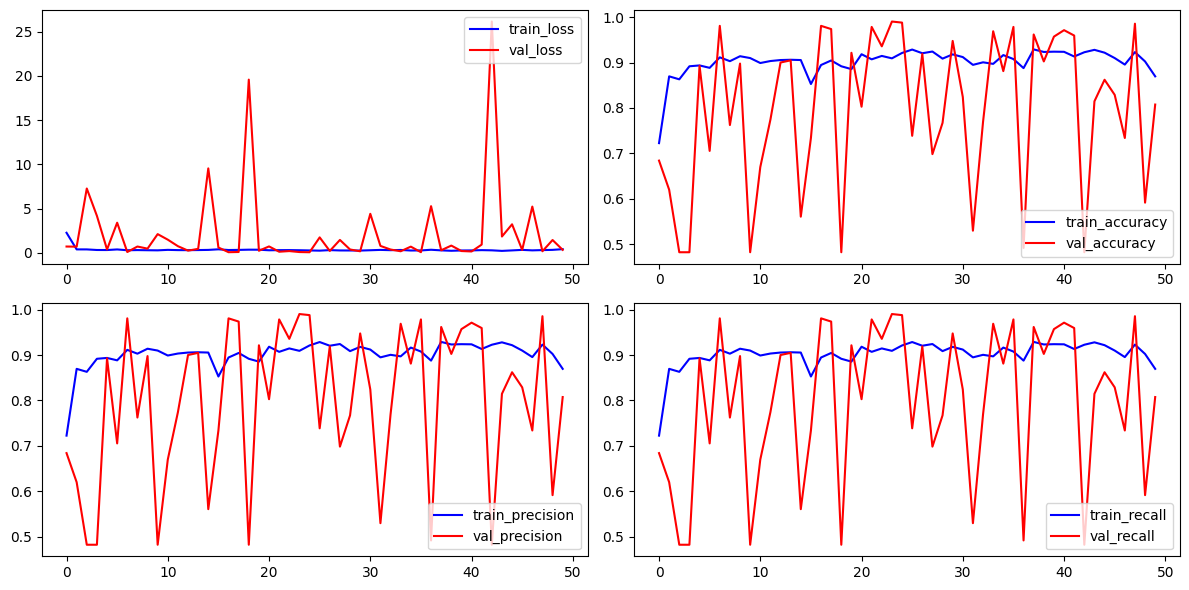

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
{'notumour': 0, 'tumour': 1}
Accuracy: 0.601965601965602
              precision    recall  f1-score   support

           0       0.55      1.00      0.71       202
           1       1.00      0.21      0.35       205

    accuracy                           0.60       407
   macro avg       0.78      0.60      0.53       407
weighted avg       0.78      0.60      0.53       407

[[202   0]
 [162  43]]
--- Starting trial: run-1
{'learning_rate': 0.001, 'dropout': 0.5, 'optimizer': 'adam'}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


KeyboardInterrupt: 

In [44]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    accuracy = tf.reduce_mean(accuracy)  # Convert to scalar if needed
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)


session_num = 0

# for num_units in HP_NUM_UNITS.domain.values:
#     for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
for dropout_rate in HP_DROPOUT.domain.values:
  for optimizer in HP_OPTIMIZER.domain.values:
    for learning_rate in HP_LEARNING_RATE.domain.values:
        hparams = {HP_LEARNING_RATE: learning_rate,
        #HP_NUM_UNITS: num_units,
        HP_DROPOUT: dropout_rate,
        HP_OPTIMIZER: optimizer,
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('logs/hparam_tuning/' + run_name, hparams)
        session_num += 1
